# Demonstration for the pipeline of RPN and GCVIT

## Imports

In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform, get_transform
# from project.preprocessing import z_score_normalization, min_max_normalization
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.rpn_to_gcvit import Feeder


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the masks and cases

In [2]:
ds = Dataset()

In [3]:
masks = ds.load_cmb_masks()
cases = ds.load_skullstripped_mri()

In [4]:
transform = NiftiToTensorTransform(target_shape=(512,512))

## Generate the dataset that will be used for the demonstration

In [5]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

### Number of masks

In [6]:
print(masks.__len__())

72


## Create the sample data for the demonstration

In [7]:
import nibabel as nib
import numpy as np

bbox_list = []

for i in range(masks.__len__()):
    ann = nib.load(masks[i]).get_fdata() # Load the image of mask
    ann = (ann > 0).astype(np.uint8)
    print(f'\nProcessing case: {i}')

    # Dictionary for the current case
    slice_bbox = {
        'case': masks[i],
        'bbox': []
    }

    for j in range(ann.shape[2]):
        bbox = dataset.extract_bounding_boxes(ann[:, :, j]) # Get the bounding box of the current slice
        slice_bbox['bbox'].append(bbox)
        print(f'Slice: {j}, count: {bbox.__len__()}')
    bbox_list.append(slice_bbox) # Append to the bbox_list

# Notification only
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)


Processing case: 0
Slice: 0, count: 0
Slice: 1, count: 0
Slice: 2, count: 0
Slice: 3, count: 0
Slice: 4, count: 0
Slice: 5, count: 0
Slice: 6, count: 0
Slice: 7, count: 0
Slice: 8, count: 2
Slice: 9, count: 1
Slice: 10, count: 0
Slice: 11, count: 1
Slice: 12, count: 2
Slice: 13, count: 0
Slice: 14, count: 0
Slice: 15, count: 1
Slice: 16, count: 5
Slice: 17, count: 2
Slice: 18, count: 0
Slice: 19, count: 0
Slice: 20, count: 0
Slice: 21, count: 0
Slice: 22, count: 0
Slice: 23, count: 0
Slice: 24, count: 0
Slice: 25, count: 0
Slice: 26, count: 0
Slice: 27, count: 1
Slice: 28, count: 0
Slice: 29, count: 0
Slice: 30, count: 0
Slice: 31, count: 0
Slice: 32, count: 0
Slice: 33, count: 0
Slice: 34, count: 0

Processing case: 1
Slice: 0, count: 0
Slice: 1, count: 0
Slice: 2, count: 0
Slice: 3, count: 0
Slice: 4, count: 0
Slice: 5, count: 0
Slice: 6, count: 0
Slice: 7, count: 0
Slice: 8, count: 0
Slice: 9, count: 0
Slice: 10, count: 0
Slice: 11, count: 0
Slice: 12, count: 0
Slice: 13, count: 0


In [8]:
bbox_list

[{'case': 'c:\\Users\\Lex Zedrick Lorenzo\\Documents\\GitHub\\Thesis_Folder\\Dataset\\VALDO_dataset\\cmb_masks_dir\\sub-101_space-T2S_CMB.nii.gz',
  'bbox': [[],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [[164, 327, 172, 336], [180, 299, 184, 303]],
   [[257, 320, 260, 324]],
   [],
   [[278, 345, 281, 348]],
   [[233, 321, 237, 324], [259, 313, 263, 317]],
   [],
   [],
   [[155, 188, 160, 192]],
   [[267, 301, 271, 306],
    [264, 294, 268, 299],
    [271, 292, 276, 296],
    [268, 220, 273, 226],
    [259, 216, 262, 220]],
   [[268, 288, 279, 299], [271, 226, 275, 230]],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [[254, 303, 258, 308]],
   [],
   [],
   [],
   [],
   [],
   [],
   []]},
 {'case': 'c:\\Users\\Lex Zedrick Lorenzo\\Documents\\GitHub\\Thesis_Folder\\Dataset\\VALDO_dataset\\cmb_masks_dir\\sub-102_space-T2S_CMB.nii.gz',
  'bbox': [[],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
 

## Create a sample output of the RPN model

In [9]:
sample_rpn_output = bbox_list[0]

## Generate cases where there is a negative coordinates in the bounding box

In [10]:
for i in range(len(sample_rpn_output['bbox'])):
    x = sample_rpn_output['bbox'][i]
    if len(x) == 0:
        sample_rpn_output['bbox'][i] = [-1, 45, 65, 58]
    else:
        sample_rpn_output['bbox'][i] = sample_rpn_output['bbox'][i][0]

In [11]:
sample_rpn_output

{'case': 'c:\\Users\\Lex Zedrick Lorenzo\\Documents\\GitHub\\Thesis_Folder\\Dataset\\VALDO_dataset\\cmb_masks_dir\\sub-101_space-T2S_CMB.nii.gz',
 'bbox': [[-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [164, 327, 172, 336],
  [257, 320, 260, 324],
  [-1, 45, 65, 58],
  [278, 345, 281, 348],
  [233, 321, 237, 324],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [155, 188, 160, 192],
  [267, 301, 271, 306],
  [268, 288, 279, 299],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [254, 303, 258, 308],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58],
  [-1, 45, 65, 58]]}

## Resize function for the cropped images

In [12]:
resize = get_transform(
    height=100,
    width=100,
    p=1.0
)

## Get the cropped image and labes and plot them

[164, 327, 172, 336]
torch.Size([35, 1, 100, 100])


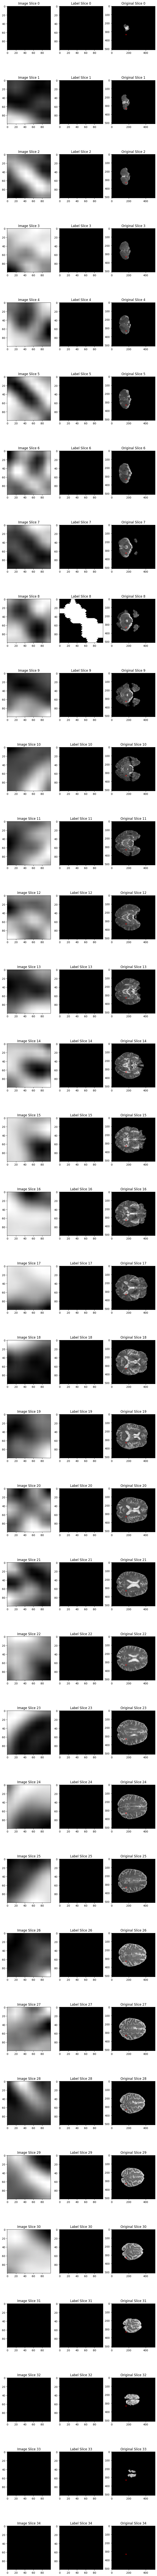

In [13]:
import matplotlib.patches as patches

for i in range(sample_rpn_output['bbox'].__len__()):
    bbox = sample_rpn_output['bbox'][i] # b_box
    img = dataset.locate_case_by_name(sample_rpn_output['case']) # find the case of the img

    connector = Feeder(resize=resize) # Initialize the feeder


    try:
        # Get the cropped image and mask
        cropped_img = connector(img[0], bbox)
        cropped_mask = connector(img[1], bbox)
    except Exception: # Skip all the slices with negative coordinates
        continue

    num_slices = cropped_img.shape[0] # Number of slices

    # Figure with numslices as rows and 3 columns
    fig, ax = plt.subplots(num_slices, 3, figsize=(10, num_slices * 5))

    print(bbox)
    print(cropped_img.shape)

    for j in range(num_slices): 
        
        # Plot image in 1st column
        ax[j, 0].imshow(cropped_img[j][0], cmap='gray')
        ax[j, 0].set_title(f'Image Slice {j}')
        
        # Plot label in secondf column
        ax[j, 1].imshow(cropped_mask[j][0], cmap='gray')
        ax[j, 1].set_title(f'Label Slice {j}')

        # Plot label in secondf column
        ax[j, 2].imshow(img[0][j][0, 0, :], cmap='gray')
        ax[j, 2].set_title(f'Original Slice {j}')

        # Create the bounding box rectangle
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),  # (x_min, y_min)
            bbox[2] - bbox[0],   # width
            bbox[3] - bbox[1],   # height
            linewidth=1, edgecolor='r', facecolor='none'  # red bounding box
        )

        # Add the rectangle to the axis
        ax[j, 2].add_patch(rect)

    plt.show()
    break
    
    # # Break if i matches your desired number of plotted case
    # if i == 10:
    #     break